In [10]:
# Importing the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
from keras.utils import np_utils
from keras.models import Model
from keras.constraints import maxnorm
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import Dropout


import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the Input Data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
# Processing the data & Scaling the data
# perform a transpose reshape from (3,32,32) to (32,32,3)
x_train = x_train.reshape(50000,3,32,32)
x_test = x_test.reshape(10000,3,32,32)

# normalize inputs from 0-255 to 0.0-1.0
x_train = x_train / 255.
x_test = x_test / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


In [5]:
# Preparing the Target Data
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
num_classes

10

In [12]:
# Implementing AutoEncoder Model

encoding_dim = 128 
input_img = Input(shape=(3072,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(3072, activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)

# Encoder and Decoder
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [13]:
# Compling the Auto Encoder
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Training the model
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.6924 - accuracy: 0.0068 - val_loss: 0.6906 - val_accuracy: 0.0075
Epoch 2/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.6858 - accuracy: 0.0085 - val_loss: 0.6800 - val_accuracy: 0.0091
Epoch 3/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.6757 - accuracy: 0.0094 - val_loss: 0.6713 - val_accuracy: 0.0097
Epoch 4/50
50000/50000 [==============================] - 10s 197us/step - loss: 0.6665 - accuracy: 0.0101 - val_loss: 0.6614 - val_accuracy: 0.0105
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.6575 - accuracy: 0.0108 - val_loss: 0.6540 - val_accuracy: 0.0111
Epoch 6/50
50000/50000 [==============================] - 10s 193us/step - loss: 0.6519 - accuracy: 0.0111 - val_loss: 0.6499 - val_accuracy: 0.0112
Epoch 7/50
50000/50000 [==============================] 

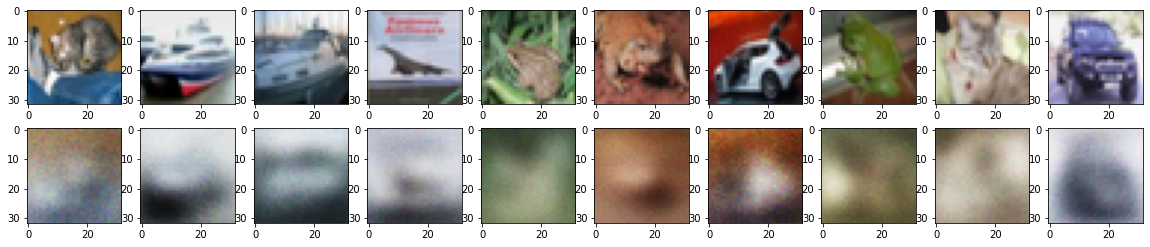

In [15]:
# Visualizing the Input and Reconstructed Images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

prediction = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32,3))

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(prediction[i].reshape(32, 32,3))
plt.show()

In [16]:
# Storing the Output of Auto Encoder to provide as input to CNN

# Traing data
x_train2 = x_train.copy()

for i in range(0, 50000):
  prediction = autoencoder.predict(x_train[i].reshape(1,3072))
  x_train2[i] = prediction

# Testing data
x_test2 = x_test.copy()

for i in range(0, 10000):
  prediction = autoencoder.predict(x_test[i].reshape(1,3072))
  x_test2[i] = prediction

In [17]:
# Changing the dimensions of data for CNN
x_train2 = np.array(x_train2).reshape([-1, 32, 32, 3]) 
x_train2.shape

x_test2 = np.array(x_test2).reshape([-1, 32, 32, 3]) 
x_test2.shape

(10000, 32, 32, 3)

In [19]:
# CNN Implementation

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history1 = model.fit(x_train2, y_train, validation_data=(x_test2, y_test), epochs=25, batch_size=32)

Epoch 1/25
1563/1563 [==============================] - 179s 115ms/step - loss: 1.8555 - accuracy: 0.3267 - val_loss: 1.6829 - val_accuracy: 0.3991
Epoch 2/25
1563/1563 [==============================] - 184s 118ms/step - loss: 1.6905 - accuracy: 0.3943 - val_loss: 1.6066 - val_accuracy: 0.4346
Epoch 3/25
1563/1563 [==============================] - 181s 116ms/step - loss: 1.6386 - accuracy: 0.4138 - val_loss: 1.5597 - val_accuracy: 0.4387
Epoch 4/25
1563/1563 [==============================] - 181s 116ms/step - loss: 1.6042 - accuracy: 0.4237 - val_loss: 1.5996 - val_accuracy: 0.4298
Epoch 5/25
1563/1563 [==============================] - 181s 116ms/step - loss: 1.5675 - accuracy: 0.4397 - val_loss: 1.5505 - val_accuracy: 0.4517
Epoch 6/25
1563/1563 [==============================] - 184s 118ms/step - loss: 1.5478 - accuracy: 0.4458 - val_loss: 1.5422 - val_accuracy: 0.4495
Epoch 7/25
1563/1563 [==============================] - 180s 115ms/step - loss: 1.5271 - accuracy: 0.4527 - val_

In [25]:
loss, accuracy = model.evaluate(x_test2, y_test, verbose=0)
print("Accuracy is:  ", (accuracy*100) )

Accuracy is:   48.53000044822693


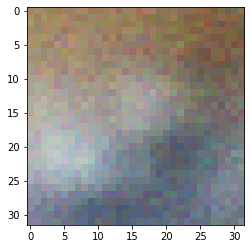

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Actual Value for :cat
Predicted Value for : cat



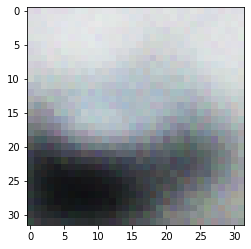

Actual Value for :ship
Predicted Value for : ship



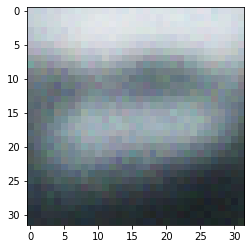

Actual Value for :ship
Predicted Value for : ship



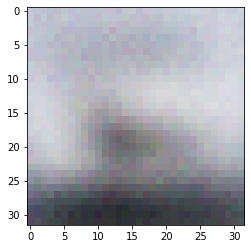

Actual Value for :airplane
Predicted Value for : airplane



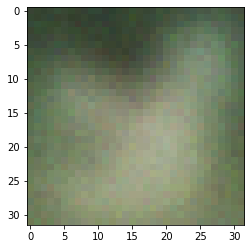

Actual Value for :frog
Predicted Value for : frog



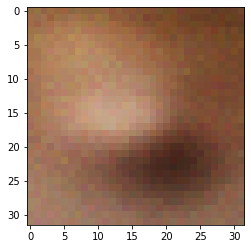

Actual Value for :frog
Predicted Value for : frog



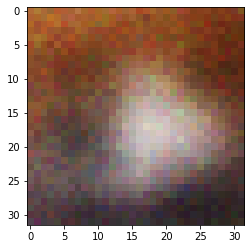

Actual Value for :automobile
Predicted Value for : automobile



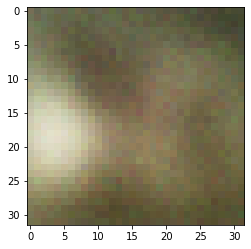

Actual Value for :frog
Predicted Value for : horse



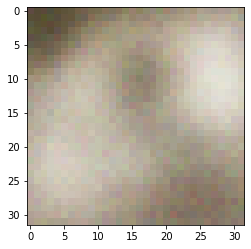

Actual Value for :cat
Predicted Value for : bird



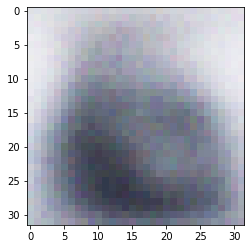

Actual Value for :automobile
Predicted Value for : truck



In [26]:
# Labels 
labels = ['airplane','automobile','bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship','truck']
for i in range(0,10):
    plt.imshow(x_test2[i,:,:])  
    plt.show()
    predicted_value = model.predict(x_test2[[i],:])
    predict_classes = model.predict_classes(x_test2[[i],:])
    actual_value = y_test[[i],:]
    print("Actual Value for :" + str(labels[np.argmax(actual_value)]))
    print("Predicted Value for : "  + str(labels[predict_classes[0]])+'\n')